<a href="https://colab.research.google.com/github/thant-san/brain-tumours-classification/blob/main/sentiment_analysis(losgistic_regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 80.2MB/s]


In [3]:
!unzip twitter-entity-sentiment-analysis.zip -d dataset/

Archive:  twitter-entity-sentiment-analysis.zip
  inflating: dataset/twitter_training.csv  
  inflating: dataset/twitter_validation.csv  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [4]:
# Load dataset
train_df = pd.read_csv('/content/dataset/twitter_training.csv')
# Assign meaningful column names
train_df.columns = ['ID', 'Entity', 'Sentiment', 'Message']

# Display basic dataset info
print("Dataset Info:")
print(train_df.info())

# View the first few records
print("\nSample Data:")
print(train_df.head())

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Entity     74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Message    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None

Sample Data:
     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                             Message  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  

Missing Values:
ID             0
Entity

In [5]:
import re

# Define text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase
    return text

# Apply cleaning
train_df['Message'] = train_df['Message'].astype(str).apply(clean_text)

# Remove missing sentiment values
train_df.dropna(subset=['Sentiment'], inplace=True)

# Convert sentiment labels to numerical values
sentiment_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_mapping)

# Remove any remaining NaN values after mapping
train_df.dropna(subset=['Sentiment'], inplace=True)

# Convert Sentiment to integer
train_df['Sentiment'] = train_df['Sentiment'].astype(int)

# Check unique sentiment values
print("\nUnique sentiment values after encoding:", train_df['Sentiment'].unique())


Unique sentiment values after encoding: [1 2 0]


In [6]:
# Convert text messages to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=15000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(train_df['Message'])
y = train_df['Sentiment']

print("Shape of feature matrix:", X.shape)

Shape of feature matrix: (61691, 15000)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (49352, 15000)
Testing set size: (12339, 15000)


In [10]:
# Define Logistic Regression model
model = LogisticRegression(max_iter=2000)

# Define parameter grid for tuning
parameters = {'C': [0.01, 0.1, 1, 10, 50, 100]}

# Perform Grid Search to find best hyperparameters
grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best parameter
best_param = grid_search.best_params_
print("Best Parameters:", best_param)

# Train final model using best parameter
best_model = LogisticRegression(C=best_param['C'], max_iter=2000)
best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_model.predict(X_test)

Best Parameters: {'C': 10}


In [12]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8555798687089715
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      4492
           1       0.88      0.85      0.86      4169
           2       0.85      0.82      0.83      3678

    accuracy                           0.86     12339
   macro avg       0.86      0.85      0.85     12339
weighted avg       0.86      0.86      0.86     12339



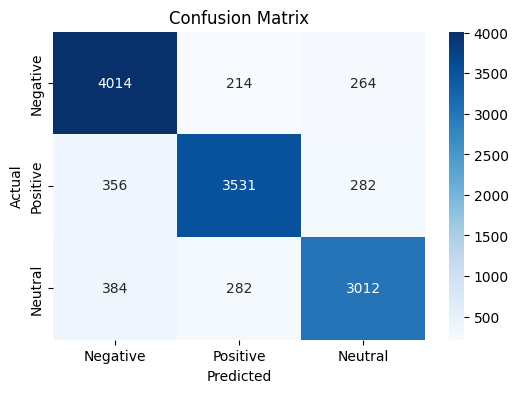

In [13]:
# Create and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
import joblib

# Save the trained model and vectorizer for future use
joblib.dump(best_model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [15]:
def predict_sentiment(message):
    message_cleaned = clean_text(message)
    message_vectorized = vectorizer.transform([message_cleaned])
    prediction = best_model.predict(message_vectorized)

    sentiment_label = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    return sentiment_label[prediction[0]]

# Test the function
new_message = "I love this product! It's amazing."
print("Predicted Sentiment:", predict_sentiment(new_message))

Predicted Sentiment: Positive
